# This script uses a Neural Network to predict number of tornado fatalities given EF rating, number of Injuries, Length (miles), and Width (yds)

In [5]:
!pip3 install ann_visualizer
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy

### 1. Import & Inspect the Data

In [7]:
# # Connect to Google Drive
# from google.colab import drive 
# drive.mount('/content/gdrive')

In [8]:
# # Loading data
# tornado_df = pd.read_csv("gdrive/My Drive/Colab Notebooks/Final_Project/2008-2020_tornadoes_EF_cleaned.csv")
# tornado_df

In [9]:
# Apache Spark Set Up

import os
# Find the latest version of spark 3.0 from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.3.0'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Fetched 252 kB in 2s (112 kB/s)
Reading package lis

In [10]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Tornadoes").getOrCreate()

In [11]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url ="https://group-2-project-tornadoes.s3.amazonaws.com/joined_torn_pop_data_2010-2019_db.csv"
spark.sparkContext.addFile(url)
tornado = spark.read.csv(SparkFiles.get("joined_torn_pop_data_2010-2019_db.csv"), sep=",", header=True)

# Show DataFrame
tornado.show()

+-------+---------+----+-----+---+-------------------+-------+---------+---------+---------+-------+--------+---+--------+----------+------+---------+------+-----+--------+
|torn_id|county_id|year|month|day|          timestamp|st_fips|cnty_fips|start_lat|start_lon|end_lat| end_lon| ef|injuries|fatalities|  loss|crop_loss|length|width|cnty_pop|
+-------+---------+----+-----+---+-------------------+-------+---------+---------+---------+-------+--------+---+--------+----------+------+---------+------+-----+--------+
|   6974|    29181|2013|   10| 31|2013-10-31 17:11:00|     29|      181|  36.5862| -90.7416|36.5744|-90.6681|  1|       0|         0|100000|     null|  4.16|  150|   13985|
|   6975|    29023|2013|   10| 31|2013-10-31 17:30:00|     29|       23|  36.6338|   -90.47|36.6351|-90.4664|  1|       0|         0| 80000|     null|  0.22|   50|   42961|
|   6976|    29023|2013|   10| 31|2013-10-31 17:48:00|     29|       23|  36.6954| -90.2691|36.7363|-90.1798|  1|       0|         0|10

In [12]:
# Convert spark object to pandas dataframe
tornado_df = tornado.toPandas()
tornado_df

,torn_id,county_id,year,month,day,timestamp,st_fips,cnty_fips,start_lat,start_lon,end_lat,end_lon,ef,injuries,fatalities,loss,crop_loss,length,width,cnty_pop
0,6974,29181,2013,10,31,2013-10-31 17:11:00,29,181,36.5862,-90.7416,36.5744,-90.6681,1,0,0,100000,None,4.16,150,13985
1,6975,29023,2013,10,31,2013-10-31 17:30:00,29,23,36.6338,-90.47,36.6351,-90.4664,1,0,0,80000,None,0.22,50,42961
2,6976,29023,2013,10,31,2013-10-31 17:48:00,29,23,36.6954,-90.2691,36.7363,-90.1798,1,0,0,100000,None,5.7,75,42961
3,6977,29017,2013,10,31,2013-10-31 17:54:00,29,17,37.25,-89.9482,37.25,-89.9209,1,0,0,70000,None,1.5,200,12481
4,6978,29207,2013,10,31,2013-10-31 18:02:00,29,207,36.7312,-90.0338,36.7637,-89.7797,1,0,0,75000,None,14.25,100,29795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11963,6956,34007,2012,9,4,2012-09-04 16:31:00,34,7,39.8772,-75.0975,39.8794,-75.0965,0,0,0,25000,None,0.16,25,511584
11964,6957,55043,2012,9,4,2012-09-04 18:37:00,55,43,42.9089,-90.995,42.9025,-90.9839,2,0,0,420000,8000,0.72,75,50871
11965,6958,39025,2012,9,7,2012-09-07 22:36:00,39,25,39.173,-84.144,39.175,-84.141,0,0,0,40000,None,0.21,25,199487
11966,6959,36081,2012,9,8,2012-09-08 08:58:00,36,81,40.5468,-73.9329,40.6337,-73.894,1,0,0,270000,None,4.74,50,2272222


In [13]:
# Check data types
tornado_df.dtypes

torn_id       object
county_id     object
year          object
month         object
day           object
timestamp     object
st_fips       object
cnty_fips     object
start_lat     object
start_lon     object
end_lat       object
end_lon       object
ef            object
injuries      object
fatalities    object
loss          object
crop_loss     object
length        object
width         object
cnty_pop      object
dtype: object

In [14]:
# Convert timestamp to datetime
tornado_df['timestamp']= pd.to_datetime(tornado_df['timestamp'])

# Convert all strings to numeric
cols=[i for i in tornado_df.columns if i not in ["timestamp"]]
for col in cols:
    tornado_df[col]=pd.to_numeric(tornado_df[col])

# check dtypes
tornado_df.dtypes

torn_id                int64
county_id              int64
year                   int64
month                  int64
day                    int64
timestamp     datetime64[ns]
st_fips                int64
cnty_fips              int64
start_lat            float64
start_lon            float64
end_lat              float64
end_lon              float64
ef                     int64
injuries               int64
fatalities             int64
loss                 float64
crop_loss            float64
length               float64
width                  int64
cnty_pop               int64
dtype: object

In [15]:
tornado_df.columns

Index(['torn_id', 'county_id', 'year', 'month', 'day', 'timestamp', 'st_fips',
       'cnty_fips', 'start_lat', 'start_lon', 'end_lat', 'end_lon', 'ef',
       'injuries', 'fatalities', 'loss', 'crop_loss', 'length', 'width',
       'cnty_pop'],
      dtype='object')

In [16]:
# drop na columns
tornado_df = tornado_df.dropna()

### 1. Define input data (X) and output data (y)

In [17]:
X = tornado_df.copy()
X = X.drop(['torn_id', 'county_id', 'year', 'month', 'day', 'timestamp', 'st_fips', 'cnty_fips', 'start_lat', 'start_lon', 'end_lat', 'end_lon','fatalities', 'loss', 'crop_loss'], axis=1)
X

,ef,injuries,length,width,cnty_pop
52,0,0,1.78,50,15179
130,1,0,0.97,100,67412
165,0,0,1.59,100,281148
195,1,0,2.32,150,18244
196,2,0,2.98,300,24207
...,...,...,...,...,...
11752,0,0,0.16,75,33601
11902,0,0,5.56,100,151482
11949,0,0,2.25,75,38837
11954,2,0,0.90,75,15710


In [18]:
y = tornado_df["fatalities"].ravel()
y[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### 2. Splitting into Train and Test sets

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state =78)

### 3. Scale the input data (X)

In [20]:
# Creating StandardScaler instance
scaler = StandardScaler()
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### 4. Define Deep Learning Model

In [21]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.

# Rule of Thumb:
#   1. Number of Layers: Start with two hidden layers (this does not include the last layer).
#   2. Number of nodes (size) of intermediate layers: a number from the geometric progression of 2, e.g., 4, 8, 16, 32, … . 
#      The first layer should be around half of the number of input data features. The next layer size as half of the previous.

number_input_features = len(X.columns)
hidden_nodes_layer1 = 4
hidden_nodes_layer2 = 2

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add( tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu") )

# Second hidden layer
nn.add( tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu") )

# Output layer
nn.add( tf.keras.layers.Dense(units=1, activation="sigmoid") )

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 24        
                                                                 
 dense_1 (Dense)             (None, 2)                 10        
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


### 5. Compile & Train the Model

In [22]:
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

In [23]:
# Compile the model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["accuracy"])

# Create a callback that saves the model's weights every epoch
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    period = 5)

In [24]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,validation_split=0.33, epochs=100,callbacks=[cp_callback])

Epoch 1/100
8/8 [==============================] - 2s 35ms/step - loss: 0.6232 - accuracy: 0.9644 - val_loss: 3.0720 - val_accuracy: 0.9279
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.6185 - accuracy: 0.9644 - val_loss: 3.0680 - val_accuracy: 0.9279
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 0.6136 - accuracy: 0.9644 - val_loss: 3.0640 - val_accuracy: 0.9279
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.6086 - accuracy: 0.9644 - val_loss: 3.0602 - val_accuracy: 0.9279
Epoch 5/100
1/8 [==>...........................] - ETA: 0s - loss: 1.5113 - accuracy: 0.9375
Epoch 5: saving model to checkpoints/weights.05.hdf5
8/8 [==============================] - 0s 9ms/step - loss: 0.6036 - accuracy: 0.9644 - val_loss: 3.0563 - val_accuracy: 0.9279
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 0.5990 - accuracy: 0.9644 - val_loss: 3.0526 - val_accuracy: 0.9279
Epoch 7/100
8/8 [=============

### 6. Save the Model

In [25]:
nn.save("NN_predictFatalities.h5")

### 7. Plot Model Performance

In [26]:
print(fit_model.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


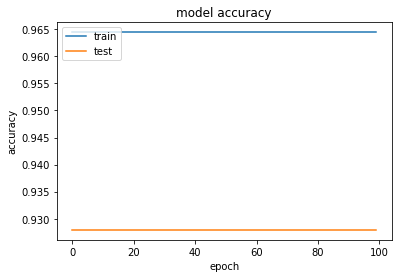

In [27]:
# summarize history for accuracy
plt.plot(fit_model.history['accuracy'])
plt.plot(fit_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


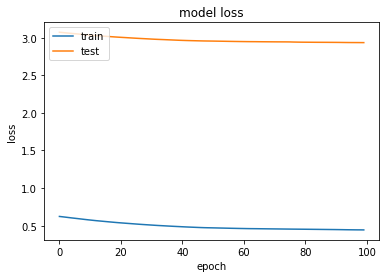

In [28]:
# summarize history for loss
plt.plot(fit_model.history['loss'])
plt.plot(fit_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
# Visualize the Neural Network
from ann_visualizer.visualize import ann_viz
ann_viz(nn,view=True, filename="NN_predictFatalities", title= "Fatalities Neural Network")

### 6. Model Accuracy

In [30]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

4/4 - 0s - loss: 0.9818 - accuracy: 0.9643 - 26ms/epoch - 6ms/step
Loss: 0.9818280339241028, Accuracy: 0.9642857313156128
